In [1]:
import sys, os
import time, random, pickle
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline

### delta_LinF9_XGB score
1. As we haven't published the paper, this feature generation and calculation for delta_LinF9_XGB score is unavailable at this stage.
2. But I have all the generated feature set in (screen/feature_set/).

In [2]:
df = pd.read_csv('screen/feature_set/inactive_Hel/poses_inactive_Hel_all.csv')
len(df)

33165

In [3]:
LigandDescriptors = ['HeavyAtomMolWt', 'NumValenceElectrons','FpDensityMorgan1', 
                     'FpDensityMorgan2', 'FpDensityMorgan3', 'LabuteASA',
                     'TPSA', 'NHOHCount', 'MolLogP','MolMR'] #

In [4]:
f_type = ["P","N","DA","D","A","AR","H","PL","HA","SA"]
SASA = ["P2." + i for i in f_type] + ["P2dl." + i for i in f_type] + ["P2dp." + i for i in f_type]
SASA = [x for x in SASA if x not in ['P2dl.HA','P2dp.HA']]

vina1 = ['vina%d'%x for x in range(2,9)]
vina2 = ['vina%d'%x for x in range(10,17)]
vina3 = ['vina%d'%x for x in range(18,25)]
vina4 = ['vina%d'%x for x in range(26,31)]
vina5 = ['vina%d'%x for x in range(32,37)]
vina6 = ['vina%d'%x for x in range(38,49)]

vina=vina1+vina2+vina3+vina4+vina5+vina6
metal = ['metal%d'%x for x in range(2,8)]
BW = ["Nbw","Epw","Elw"]

columns = vina+['ligCover','betaScore','LE']+SASA+metal+LigandDescriptors+BW
len(columns)
len(columns)

92

In [5]:
X = np.c_[df[columns]]
X = X.astype(np.float64)
y_fix = np.r_[df['LinF9']]

We have trained ten XGB models, the final XGB score is the average of ten XGB model's outputs

In [6]:
y_predict_ = []
for i in range(1,11):
    xgb_model = pickle.load(open("/home/cyang/XGB/decoys/saved_model/20_44/mod_12_%d.pickle.dat"%i,"rb"))
    y_i_predict = xgb_model.predict(X, ntree_limit=xgb_model.best_ntree_limit)
    y_predict_.append(y_i_predict)

y_predict = np.average(y_predict_, axis=0)

In [7]:
df['XGB'] = pd.Series(y_predict+y_fix, index=df.index)

In [8]:
df = df[['ligand_id','o_index','rep','new_smile','HeavyAtomCount','ligCover','betaScore','LinF9','XGB']]

In [10]:
df = df.sort_values(by=['ligand_id','XGB'], ascending=[True,False])
df1 = df.drop_duplicates('ligand_id')
len(df1)

6633

In [11]:
df1.to_csv('screen/feature_set/inactive_Hel/poses_inactive_Hel_XGB.csv', index=False)

### Select compounds by both XGB_score and pocket information

In [12]:
df = pd.read_csv('screen/feature_set/inactive_Hel/poses_inactive_Hel_XGB.csv')
df['XGB_score'] = round(df['XGB']/(-0.73349),3)
df['XGB_LE'] = round(df['XGB_score']/df['HeavyAtomCount'],3)

In [13]:
df.head(2)

,ligand_id,o_index,rep,new_smile,HeavyAtomCount,ligCover,betaScore,LinF9,XGB,XGB_score,XGB_LE
0,2316,5,AFv1,Cn1nnc2c(=O)n(Cc3cccc4ccccc34)cnc21,22,0.909,-7.4,5.696,5.615775,-7.656,-0.348
1,2321,5,AFv1,O=C(Cc1cccc2ccccc12)Nc1c[nH]c(=O)[nH]c1=O,22,0.955,-7.5,5.604,5.376227,-7.330,-0.333


Text(0.5, 1.0, 'XGB re-scoring of 6633 compounds')

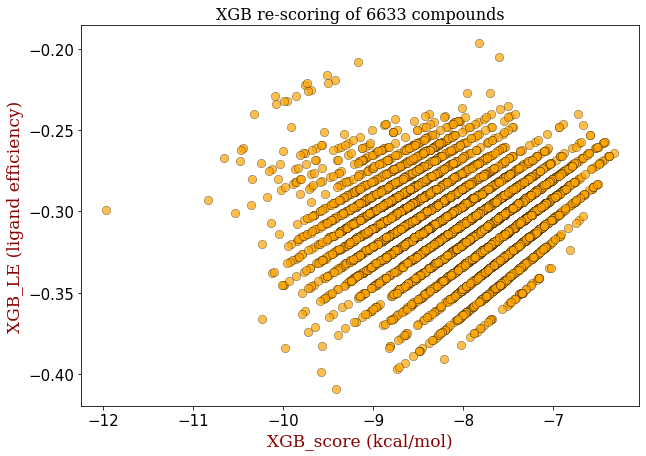

In [14]:
plt.figure(figsize=[10,7])
plt.scatter(df['XGB_score'],df['XGB_LE'],edgecolor='k',color='orange', s=70, alpha=0.7,linewidths=0.4)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 17,
        }
font1 = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 16,
        }
font2 = {'family': 'serif',
        'color':  'r',
        'weight': 'normal',
        'size': 14,
        }
plt.xlabel('XGB_score (kcal/mol)', fontdict=font)
plt.ylabel('XGB_LE (ligand efficiency)', fontdict=font)
plt.title('XGB re-scoring of 6633 compounds',fontdict=font1)

Based on the XGB_score, XGB_LE, ligCover and betaScore to select some compounds
1. XGB_score is rescoring using XGB model.
2. XGB_LE is XGB_score/HeavyAtomCount.
3. ligCover is the precentage of ligand atoms inside the pocket (0<=ligCover<=1).
4. betaScore is the sum scores of betaAtoms (psudo atoms) that match the docked pose of the ligand.

In [21]:
## active ATP : 
### df1 = df.loc[(df['XGB_score']<-10.0)&(df['XGB_LE']<=-0.30)&(df['ligCover'] > 0.9)&(df['betaScore']<-12.5)]
## active pep :
### df1 = df.loc[(df['XGB_score']<-8.0)&(df['XGB_LE']<=-0.24)&(df['ligCover'] > 0.7)&(df['betaScore']<-8.0)]
## inactive ATP :
### df1 = df.loc[(df['XGB_score']<-10.5)&(df['XGB_LE']<=-0.30)&(df['ligCover'] > 0.9)&(df['betaScore']<-13.0)]
## inactive Hel :
df1 = df.loc[(df['XGB_score']<-9.5)&(df['XGB_LE']<=-0.30)&(df['ligCover'] > 0.9)&(df['betaScore']<-10.5)]
print (len(df1))

11


Text(0.5, 1.0, 'Select 11 compounds')

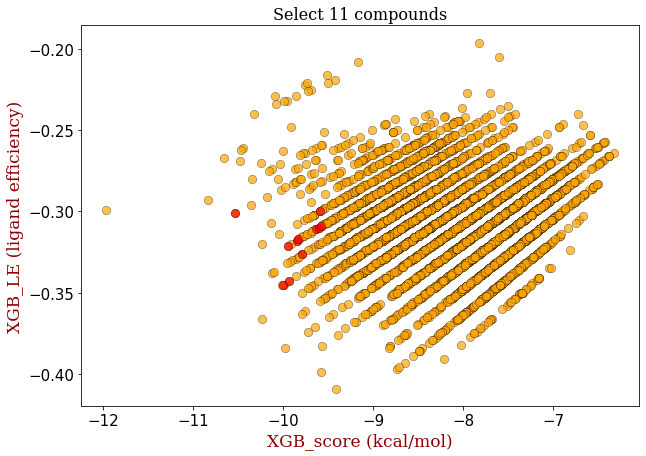

In [22]:
plt.figure(figsize=[10,7])
plt.scatter(df['XGB_score'],df['XGB_LE'],edgecolor='k',color='orange', s=70, alpha=0.7,linewidths=0.4)
plt.scatter(df1['XGB_score'],df1['XGB_LE'],edgecolor='k',color='red', s=70, alpha=0.7,linewidths=0.4)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 17,
        }
font1 = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 16,
        }
font2 = {'family': 'serif',
        'color':  'r',
        'weight': 'normal',
        'size': 14,
        }
plt.xlabel('XGB_score (kcal/mol)', fontdict=font)
plt.ylabel('XGB_LE (ligand efficiency)', fontdict=font)
plt.title('Select 11 compounds',fontdict=font1)

Plot the XGB_score vs ligand coverage for these compounds

Text(0.5, 1.0, 'Select 11 compounds')

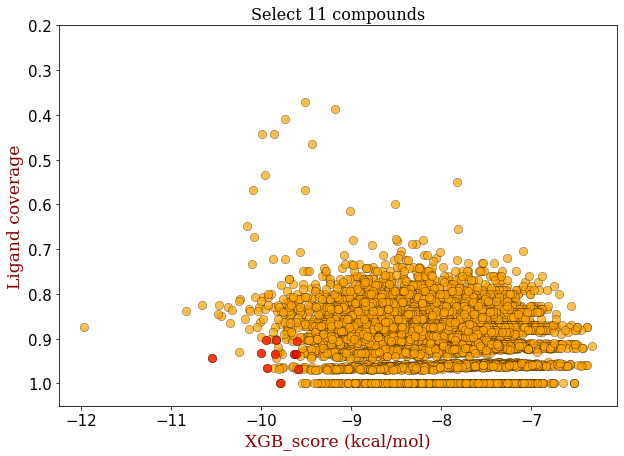

In [23]:
plt.figure(figsize=[10,7])
plt.scatter(df['XGB_score'],df['ligCover'],edgecolor='k',color='orange', s=70, alpha=0.7,linewidths=0.4)
plt.scatter(df1['XGB_score'],df1['ligCover'],edgecolor='k',color='red', s=70, alpha=0.7,linewidths=0.4)
plt.ylim(1.05,0.2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 17,
        }
font1 = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 16,
        }
font2 = {'family': 'serif',
        'color':  'r',
        'weight': 'normal',
        'size': 14,
        }
plt.xlabel('XGB_score (kcal/mol)', fontdict=font)
plt.ylabel('Ligand coverage', fontdict=font)
plt.title('Select 11 compounds',fontdict=font1)

Plot the XGB_score vs betaScore

Text(0.5, 1.0, 'Select 11 compounds')

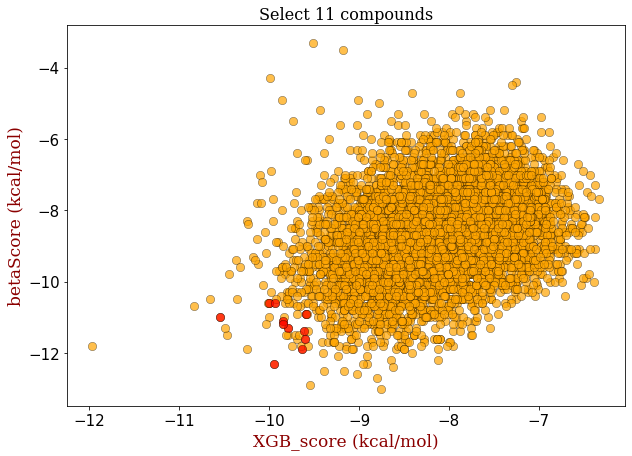

In [24]:
plt.figure(figsize=[10,7])
plt.scatter(df['XGB_score'],df['betaScore'],edgecolor='k',color='orange', s=70, alpha=0.7,linewidths=0.4)
plt.scatter(df1['XGB_score'],df1['betaScore'],edgecolor='k',color='red', s=70, alpha=0.7,linewidths=0.4)
#plt.ylim(1.05,0.2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 17,
        }
font1 = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 16,
        }
font2 = {'family': 'serif',
        'color':  'r',
        'weight': 'normal',
        'size': 14,
        }
plt.xlabel('XGB_score (kcal/mol)', fontdict=font)
plt.ylabel('betaScore (kcal/mol)', fontdict=font)
plt.title('Select 11 compounds',fontdict=font1)

In [25]:
df1.to_csv('screen/screen_XGB_and_pocket/round2_inactive_Hel.csv', index=False)

### Show these selected compounds

In [26]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdFMCS, Descriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [27]:
mols = []
Name = []

for i,j,k in zip(df1['new_smile'], df1['ligand_id'], df1['XGB_score']):
    mol = Chem.MolFromSmiles(i)
    mols.append(mol)
    Name.append('ID: %d | %.2f kcal/mol'%(j,k))

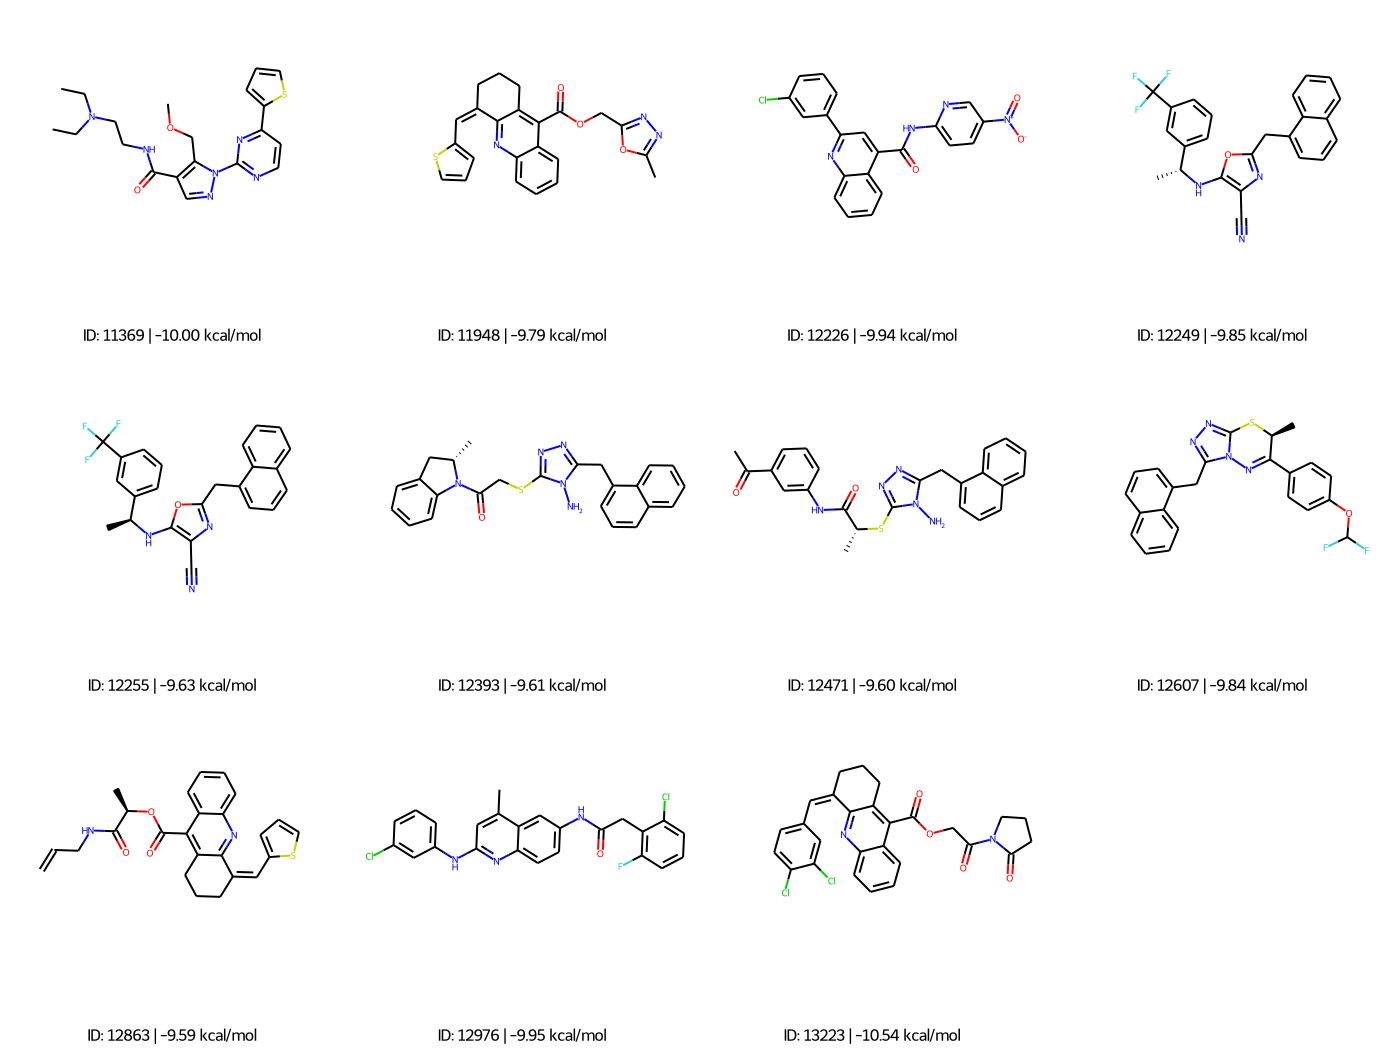

In [28]:
Chem.Draw.MolsToGridImage(mols,molsPerRow=4,subImgSize=(350, 350),legends=Name)